In [25]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [26]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [27]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [28]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [91]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine, reflect=True)


In [30]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [31]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [45]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [48]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).\
        first()
print(recent_date)


('2017-08-23',)


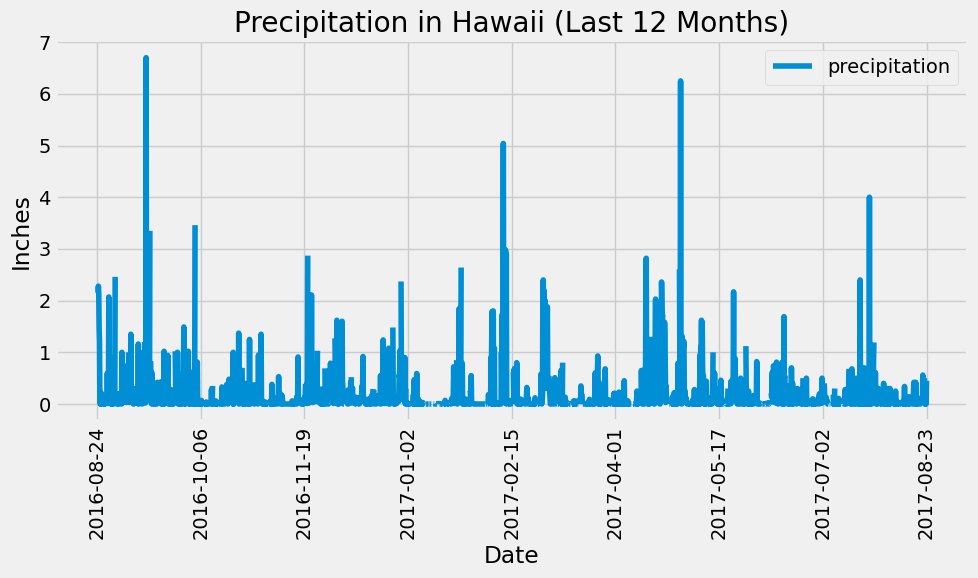

In [75]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database. 
latest_date = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).\
        first()[0]
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
one_year_ago = latest_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date>= one_year_ago).\
        all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['date', 'precipitation'])

# Sort the dataframe by date
df = df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='date', y='precipitation', figsize=(10,6))
plt.title("Precipitation in Hawaii (Last 12 Months)")
plt.xlabel("Date")
plt.ylabel("Inches")

# Calculate the positions and labels for the x ticks
tick_positions = np.linspace(0, len(df)-1, 9, dtype=int)
tick_labels = [df['date'].iloc[pos] for pos in tick_positions]

plt.xticks(tick_positions, tick_labels, rotation=90)
plt.tight_layout()
plt.show()

In [76]:
#Use pandas to print the summary statistics for the precipitation data
df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [77]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(Station).count()
print(f'There are {station_count} stations in the dataset.')



There are 9 stations in the dataset.


In [78]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).\
            all()

# List the stations and their counts in descending order.
for station, count in most_active_stations:
    print(f'Station {station} has {count} observations.')

Station USC00519281 has 2772 observations.
Station USC00519397 has 2724 observations.
Station USC00513117 has 2709 observations.
Station USC00519523 has 2669 observations.
Station USC00516128 has 2612 observations.
Station USC00514830 has 2202 observations.
Station USC00511918 has 1979 observations.
Station USC00517948 has 1372 observations.
Station USC00518838 has 511 observations.


In [82]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = most_active_stations[0][0]
print(f'The most active station is {most_active_station}.')
# Calculate the lowest temperature recorded
lowest_temp = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).\
        scalar()
# Calculate the highest temperature recorded
highest_temp = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).\
        scalar()
# Calculate the average temperature recorded
average_temp = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).\
        scalar()

print(f'The lowest temperature recorded at station this station is {lowest_temp} degrees Fahrenheit.')
print(f'The highest temperature recorded at station this station is {highest_temp} degrees Fahrenheit.')
print(f'The average temperature recorded at station this station is {average_temp} degrees Fahrenheit.')


The most active station is USC00519281.
The lowest temperature recorded at station USC00519281 is 54.0 degrees Fahrenheit.
The highest temperature recorded at station USC00519281 is 85.0 degrees Fahrenheit.
The average temperature recorded at station USC00519281 is 71.66378066378067 degrees Fahrenheit.


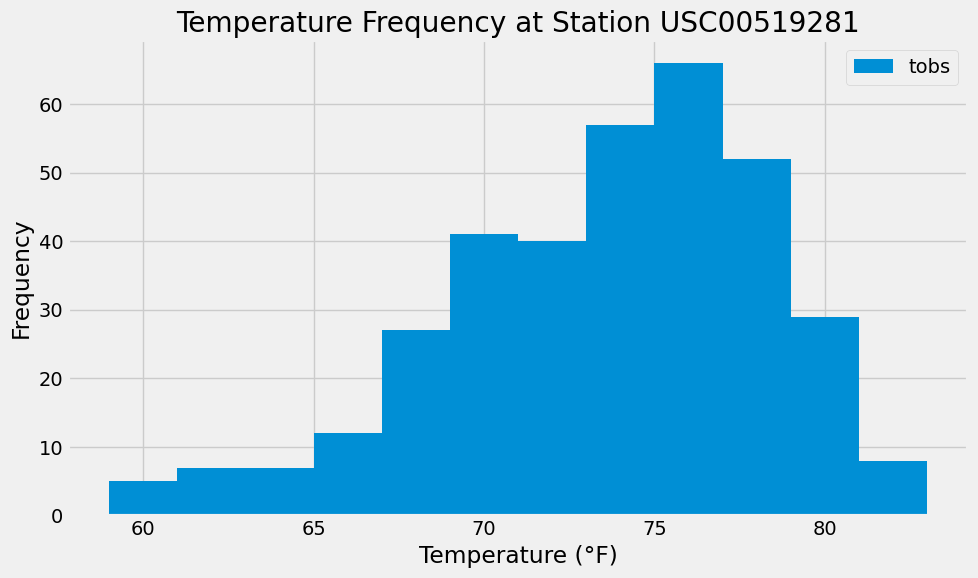

In [89]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_temps = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
        filter(Measurement.date >= one_year_ago).\
            all()

# Save the query results as a Pandas DataFrame
df = pd.DataFrame(most_active_station_temps, columns=['temperature'])

# Plot the results as a histogram
df.plot.hist(bins=12, figsize=(10,6))
plt.title(f'Temperature Frequency at Station {most_active_station}')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.legend(['tobs'])
plt.tight_layout()
plt.show()

# Close Session

In [90]:
# Close Session
session.close()